# H.4] Imaginary Time Evolution
d) Numerically integrate random initial state up to certain time $\tau_{\text{max}}$

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import reduce
from scipy.sparse import identity, kron, csr_matrix
from scipy.linalg import expm, eigh
from scipy.sparse.linalg import expm_multiply

In [2]:
# Set parameters
N = 4
tau_max = 10_000
Nsteps = 1000
dt = tau_max/Nsteps

In [3]:
# Create random initial state
psi0 = np.random.randn(2**N) + 1j*np.zeros(2**N)

# Normalize
psi0 /= np.linalg.norm(psi0) 
print('Initial state |psi(0)> = ', psi0)

Initial state |psi(0)> =  [ 0.42472527+0.j -0.32745885+0.j  0.13756585+0.j  0.24896666+0.j
  0.21591819+0.j -0.39640004+0.j  0.41888496+0.j  0.06432789+0.j
 -0.05436236+0.j -0.31680814+0.j -0.32977791+0.j  0.02723462+0.j
 -0.12376075+0.j  0.12815219+0.j -0.03119488+0.j  0.05082676+0.j]


In [32]:
# Create Hamiltonian as matrix as done in last sheet:

# Create csr Pauli matrices
id = identity(2, format='csr')
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=np.float64)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=np.float64)

def kronecker(operators):
    # reduce calls the function (first arg) recursively on the list (second arg)
    return reduce(kron, operators)

def build_operator(operator, ind, L):
    # list of L identity operators
    operators = [id] * L

    # replace the ind-th operator with the given operator
    operators[ind] = operator

    # return the kronecker product of all identity matrices and the operator on site ind
    return csr_matrix(kronecker(operators))

def all_operators(operator):
    # a list of L operators, each one acting on a different site, otherwise identity
    return [build_operator(operator, j, N) for j in range(N)]

def Hamiltonian(h=1, J=1, N=4):
    # initialize matrices
    H = csr_matrix((2**N, 2**N), dtype=np.complex128)
    sz_list = all_operators(sigma_z)
    sx_list = all_operators(sigma_x)

    for i in range(N-1):
        H += -J*(sz_list[i] @ sz_list[i+1]) - h*(sx_list[i])
    return H

In [22]:
# Define derivative using imaginary time SEQ
def dpsi_dtau(tau, psi, h=1, J=1):
    psi = psi.view(dtype=np.complex128) / np.linalg.norm(psi.view(dtype=np.complex128))
    return (-Hamiltonian(h,J) @ psi).view(dtype=np.float64) 

# Numerically integrate this state
sol = solve_ivp(dpsi_dtau, t_span = (0, tau_max), y0 = psi0.view(dtype=np.float64), t_eval=np.linspace(0, tau_max, Nsteps))

# Normalize wave functions of each step dt
psi_tau_list = sol.y.T.copy().view(dtype=np.complex128)   # copy to ensure that the memory is laid out contiguously before using changing the data type to complex128

# note: normalization should take place in every step here, however, we are not running into numerical issues
# print(np.array([np.linalg.norm(psi) for psi in psi_tau_list]))
# print(np.linalg.norm(psi_tau_list, axis=1))
psi_tau_normalized = np.array([psi / np.linalg.norm(psi) for psi in psi_tau_list])

In [34]:
H = Hamiltonian(h=2, J=1)
H = H.todense()
print(H)

e, v = eigh(H)
print(e)

[[-3.+0.j  0.+0.j -2.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j  0.+0.j -2.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j -2.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j  0.+0.j
  -2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-2.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j
   0.+0.j -2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -2.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j -2.+0.j  0.+0.j
   0.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [-2.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -2.+0.j  0.+0.j  0.+0.j  0.+0.j  3.+0.j  0.+0.j -2.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j -2.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -2.+0.j  0.+0.j -2.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -2.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -2.+0.j  0.+0.j -2.+0.j  0.+0.j -1.+0.j  0.

In [23]:
def compute_ground_overlap(psi, H_dense):
    eigvals, eigvecs = eigh(H_dense)
    delta = np.abs(eigvals[1] - eigvals[0])

    if delta < 1e-10:
        v1, v2 = eigvecs[:, 0], eigvecs[:, 1]
        proj = np.abs(np.vdot(v1, psi))**2 + np.abs(np.vdot(v2, psi))**2
        print(f"Warning: Ground state degeneracy detected. Delta = {delta:.2e}")
    else:
        v1 = eigvecs[:, 0]
        proj = np.abs(np.vdot(v1, psi))**2
    return proj

In [29]:
# Parameters
L = 4
T = 10.0
h, J = 2.0, 1.0
timesteps = 100
times = np.linspace(0, T, timesteps)
dt = times[1] - times[0]

# Initial state and normalization
psi = np.random.randn(2**N) + 1j*np.zeros(2**N)
psi /= np.linalg.norm(psi) 

energies = []
overlaps = []

for t in times[:]:
    H_sparse = Hamiltonian(h, J)
    H_dense = H_sparse.toarray()
    
    energy = np.real(psi.conj().T @ H_dense @ psi)
    energies.append(energy)

    overlaps.append(compute_ground_overlap(psi, H_dense))
    
    psi = expm_multiply(-H_sparse * dt, psi)
    psi /= np.linalg.norm(psi)

e) Monitor convergence to ground state energy

In [11]:
# Compute energy expectation value
def E(psi, h=1, J=1):
    psi = psi.view(dtype=np.complex128)
    return np.real(np.dot(psi.conjugate().T, Hamiltonian(h, J) @ psi))      # imaginary part is of order e-17 (can be discarded)

E_tau = np.array([])
tau_list = np.linspace(0, tau_max, Nsteps)
for i in range(Nsteps):
    E_tau = np.append(E_tau, E(psi_tau_normalized[i]))

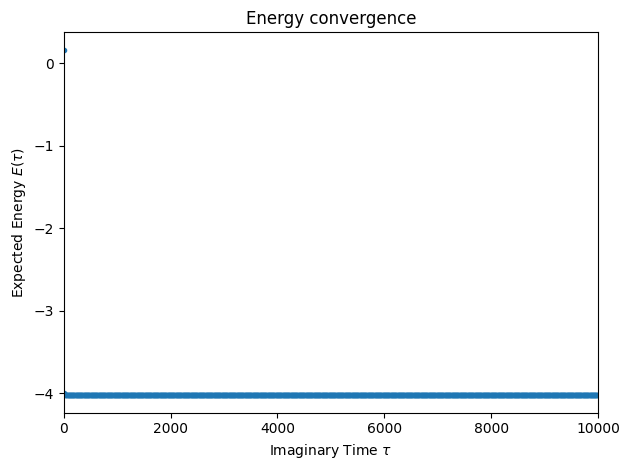

In [12]:
# Plot energy expectation value over time tau
plt.scatter(tau_list, E_tau, marker='.')

plt.xlabel(r'Imaginary Time $\tau$')
plt.ylabel(r'Expected Energy $E(\tau)$')
plt.title('Energy convergence')
plt.xlim(min(tau_list),max(tau_list))

plt.tight_layout()
plt.show()

f) Check if ITP ground state is correct

The ground state is twice degenerate, so our ITP state will be located in the subspace spanned by $|\psi_\text{GS,1}>$ and $|\psi_\text{GS,2}>$. We calculate the maximal overlap with one of those ground states. Additionally the following relation should hold
\begin{equation*}
    |<ITP|\psi_\text{GS,1}>|^2 + |<ITP|\psi_\text{GS,2}>|^2 = 1.
\end{equation*}

In [78]:
ITP_groundstate = psi_tau_normalized[-1]
exact_energies, exact_eigenstates = eigh(Hamiltonian().toarray())

# compute overlap with exact eigenstates, all states are normalized
overlaps = np.array([])
for i in range(2):   # degenerate ground state energy -> compute overlap with both ED ground states
    overlaps = np.append(overlaps, np.abs(np.real(np.dot(ITP_groundstate.conjugate().T, exact_eigenstates[:,i]))))  # again, complex part close to machine precision

print("Maximal overlap of ground state obtained with ITP and exact diagonalization: ", max(overlaps)) # overlaps vary depending on overlap of random initial state with the true ground state. maximum achieved overlap: 0.9985843368309988
print(overlaps[0]**2 + overlaps[1]**2)  # should be close to 1, but not exactly 1 due to numerical errors

print("ED ground state energy: ", exact_energies[0])
print("ITP ground state energy: ", E_tau[-1])

Maximal overlap of ground state obtained with ITP and exact diagonalization:  0.8794572774350365
0.9999657260591066
ED ground state energy:  -4.027339492125851
ITP ground state energy:  -4.027286891847819


g) Compare efficiency of ITP vs real-time adiabatic evolution

The main cost occurs in the integration, which uses the RK45 method. Depending on the initial overlap with the true ground state, the ITP method requires around 1000 time steps to find a wavefunction overlapping with the ground state by ~99.99%. However, for some initial random states the resulting overlap reaches lower values. The adiabatic search requires many more time steps in the integration in order to evolve slowly enough to not leave the ground state. However, a comparison of efficiency is difficult, since the result of the adiabatic search does not match the eigenstate obtained with exact diagonalization. 

Additionally, the adiabatic search starts in a ground state with considerable overlap with the ground state of interest. The ITP method might lead to constantly reliable results if it would follow the same procedure. Also, other integration methods (e.g. computationally cheaper ones, like Euler's method) might work better for the time grid of adiabatic search than for the one of imaginary time propagation.

### Run for multiple different initial states

In [120]:
iterations = 200
tau_max, Nsteps = 5_000, 1000
h, J = 1, 1

ed_energies, ed_eigenstates = eigh(Hamiltonian().toarray())
ed_groundstate_energy = ed_energies[0]

subspace_check = []
rel_energy_error = []
for i in range(iterations):
    psi0 = np.random.randn(2**N) + 1j*np.zeros(2**N)
    psi0 /= np.linalg.norm(psi0)

    sol = solve_ivp(dpsi_dtau, t_span = (0, tau_max), y0 = psi0.view(dtype=np.float64), t_eval=np.linspace(0, tau_max, Nsteps))
    psi_tau_list = sol.y.T.copy().view(dtype=np.complex128)  

    itp_groundstate = psi_tau_list[-1]
    itp_groundstate /= np.linalg.norm(itp_groundstate)
    itp_energy = E(itp_groundstate, h, J)
    rel_energy_error.append((itp_energy - ed_groundstate_energy) / abs(ed_groundstate_energy))

    overlap = [np.real(np.dot(itp_groundstate.conjugate().T, ed_eigenstates[:,i])) for i in range(2)]
    subspace_check.append(overlap[0]**2 + overlap[1]**2)

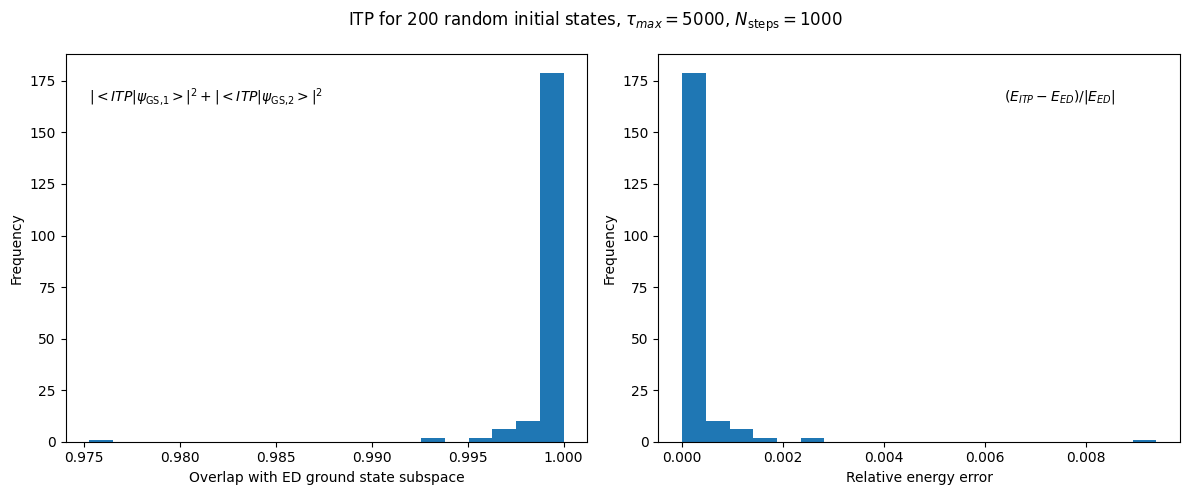

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(fr'ITP for {iterations} random initial states, $\tau_{{max}} = {tau_max}$, $N_\text{{steps}} = {Nsteps}$')

ax[0].hist(subspace_check, bins=20)
ax[0].set_xlabel('Overlap with ED ground state subspace')
ax[0].set_ylabel('Frequency')

ax[1].hist(rel_energy_error, bins=20)
ax[1].set_xlabel('Relative energy error')
ax[1].set_ylabel('Frequency')

ax[0].text(0.27, 0.89, r'$|<ITP|\psi_\text{GS,1}>|^2 + |<ITP|\psi_\text{GS,2}>|^2$', ha='center', va='center', transform=ax[0].transAxes)
ax[1].text(0.77, 0.89, r'$(E_{ITP} - E_{ED}) / |E_{ED}|$', ha='center', va='center', transform=ax[1].transAxes)


plt.tight_layout()
